In [1]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import shap
import time
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

#import eli5
from sklearn.metrics import f1_score
import numpy as np
import random
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
import statistics as st
random.seed(723)
np.random.seed(723)

In [ ]:
##Me conecto al contenido de mi drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##Establezco la carpeta donde se encuentran los datos con los que trabajaré

In [3]:
%cd "/content/drive/MyDrive/INRIA/sesion5_XGBoost/Sesion4_XGBoost"

/content/drive/MyDrive/INRIA/sesion5_XGBoost/Sesion4_XGBoost


In [ ]:
##Reviso la lista de elementos que se encuentran en esa carpeta para asegurarme que está el archivo que necesito con los datos

In [4]:
! ls

'=4.0.0'		      matrix_M3_sample_vs_KO_extended.tsv
 KO_trans.csv		      matrix_M3_sample_vs_KO.tsv
 KO_trans_v2.csv	      metadata_proka_province_corrected.csv
 matrix_M2_sample_vs_EC.tsv   XGBoost


In [ ]:
###Creo un dataframe con los datos

In [5]:
df2=pd.read_csv("KO_trans_v2.csv")
df2.head(3)

,Sample,Layer,polar,map00010,map00020,map00030,map00040,map00051,map00052,map00053,...,map01059,map01062,map01100,map01110,map01120,map01200,map01210,map01212,map01220,map01230
0,TSC000,DCM,non polar,1.119952,0.941423,0.585742,0.251439,0.505877,0.272811,0.225232,...,0.000438,0.021880,18.060134,8.519117,5.563805,3.390730,1.083733,0.852593,0.244985,3.933568
1,TSC001,SRF,non polar,1.101400,0.891961,0.575689,0.270316,0.510958,0.280575,0.228933,...,0.000634,0.028827,18.266869,8.772612,5.520142,3.277820,1.100613,0.798947,0.266316,4.064124
2,TSC002,DCM,non polar,1.165792,1.061998,0.559934,0.274357,0.471123,0.256808,0.238579,...,0.000379,0.016965,17.764422,8.272601,5.856122,3.628726,1.154244,0.833268,0.296101,3.700582


In [ ]:
###Instalo los paquetes que necesitaré

In [6]:
%%capture
!pip install scprep phate umap-learn

In [7]:
%%capture
!pip install umap-learn[plot]

In [8]:
%%capture
!pip install joblib==1.1.0

In [9]:
%%capture
!pip install hdbscan

In [10]:
%%capture
!pip install kora

In [11]:
%%capture
!pip install kaleido
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [12]:
%%capture
!pip install git+https://github.com/SZJShuffle/pySankey2.git

In [ ]:
###Aquí llamo a los paquetes que usaré para activarlos 

In [14]:
import umap.umap_ as umap
from umap import UMAP
import hdbscan 
import plotly.express as px

In [ ]:
##Programo el UMAP

In [15]:
umap_datosimp = umap.UMAP(n_neighbors=50,n_components=3, min_dist=0.1, spread=1.0,random_state=42)
umap_datosimp_3D = umap_datosimp.fit_transform(df2.drop(columns=["Sample","Layer","polar"]))

labels_umap_datosimp_3D= hdbscan.HDBSCAN().fit_predict(umap_datosimp_3D)

In [16]:
labels_umap_datosimp_colors_v2=labels_umap_datosimp_3D.astype(str)
labels_umap_datosimp_colors_v2
df2["clusterID"]= pd.Series(labels_umap_datosimp_colors_v2)
df2.head()

,Sample,Layer,polar,map00010,map00020,map00030,map00040,map00051,map00052,map00053,...,map01062,map01100,map01110,map01120,map01200,map01210,map01212,map01220,map01230,clusterID
0,TSC000,DCM,non polar,1.119952,0.941423,0.585742,0.251439,0.505877,0.272811,0.225232,...,0.021880,18.060134,8.519117,5.563805,3.390730,1.083733,0.852593,0.244985,3.933568,1
1,TSC001,SRF,non polar,1.101400,0.891961,0.575689,0.270316,0.510958,0.280575,0.228933,...,0.028827,18.266869,8.772612,5.520142,3.277820,1.100613,0.798947,0.266316,4.064124,1
2,TSC002,DCM,non polar,1.165792,1.061998,0.559934,0.274357,0.471123,0.256808,0.238579,...,0.016965,17.764422,8.272601,5.856122,3.628726,1.154244,0.833268,0.296101,3.700582,1
3,TSC003,SRF,non polar,1.164434,1.073246,0.576594,0.249180,0.480180,0.258387,0.217253,...,0.022803,17.743316,8.583348,5.805674,3.558970,1.160866,0.888450,0.257989,3.968918,1
4,TSC004,DCM,non polar,1.159713,0.954830,0.603072,0.252174,0.509795,0.263678,0.217387,...,0.026908,18.025123,8.506408,5.685068,3.412296,1.110973,0.836426,0.277571,3.945493,1


In [ ]:
###Aquí graficaré los datos del UMAP

In [17]:
UMAP_datosimp = px.scatter_3d(umap_datosimp_3D, x=0, y=1, z=2,width=1200, height=900,opacity=.4,
                                     template="plotly_white", color=labels_umap_datosimp_colors_v2,
                              hover_name=df2.Sample,
                                     labels={"0": "Dimension 1 (UMAP)","1": "Dimension 2 (UMAP)","2": "Dimension 3 (UMAP)"})
UMAP_datosimp.update_traces(marker_size=12)
UMAP_datosimp.update_layout(legend_itemsizing="trace", legend_bgcolor="white", legend_font_size=30, legend_title="Location", font=dict( size=16))
UMAP_datosimp.show()

In [ ]:
###OJO: el hover_name es para que nos diga el nombre del punto sobre el que posicionemos el cursor

In [18]:
i= df2[(df2.Sample=="TSC269")].index


In [19]:
df3=df2
df3.shape

(173, 168)

In [20]:
df3=df3.drop(i)
df3.shape

(172, 168)

In [21]:
####ahora sí hago el umap por capa #### 
labels_umap_datosimp_colors_v3= df2.Layer
labels_umap_datosimp_colors_v3


0      DCM
1      SRF
2      DCM
3      SRF
4      DCM
      ... 
168    SRF
169    SRF
170    DCM
171    MES
172    SRF
Name: Layer, Length: 173, dtype: object

In [22]:
UMAP_datosimp_capa = px.scatter_3d(umap_datosimp_3D, x=0, y=1, z=2,width=1200, height=900,opacity=.4,
                                     template="plotly_white", color=labels_umap_datosimp_colors_v3,
                              hover_name=df2.polar,
                                     labels={"0": "Dimension 1 (UMAP)","1": "Dimension 2 (UMAP)","2": "Dimension 3 (UMAP)"})
UMAP_datosimp_capa.update_traces(marker_size=12)
UMAP_datosimp_capa.update_layout(legend_itemsizing="trace", legend_bgcolor="white", legend_font_size=30, legend_title="Location", font=dict( size=16))
UMAP_datosimp_capa.show()

In [ ]:
##Ahora hacer XGboost con la columna cluster como target, y todo el resto (menos sample,  cluster y layer) será mi feature 


In [23]:
target = df3["clusterID"]
display(target.head(2))


0    1
1    1
Name: clusterID, dtype: object

In [24]:
features = df3.drop(columns=['Sample', 'Layer', 'polar','clusterID'])
display(features.head(2))

,map00010,map00020,map00030,map00040,map00051,map00052,map00053,map00061,map00062,map00071,...,map01059,map01062,map01100,map01110,map01120,map01200,map01210,map01212,map01220,map01230
0,1.119952,0.941423,0.585742,0.251439,0.505877,0.272811,0.225232,0.534429,0.002107,0.641682,...,0.000438,0.021880,18.060134,8.519117,5.563805,3.39073,1.083733,0.852593,0.244985,3.933568
1,1.101400,0.891961,0.575689,0.270316,0.510958,0.280575,0.228933,0.517550,0.000758,0.586423,...,0.000634,0.028827,18.266869,8.772612,5.520142,3.27782,1.100613,0.798947,0.266316,4.064124


In [25]:
seed = 110
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.20, 
                                                    random_state=seed, 
                                                    shuffle=True, 
                                                    stratify=target)

In [26]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 0 to 172
Columns: 164 entries, map00010 to map01230
dtypes: float64(164)
memory usage: 221.7 KB


In [27]:
xgboot_clusterID_classification = XGBClassifier(
    tree_method = "gpu_hist",
    objective='binary:hinge',
    random_state=seed, 
    eval_metric=["error", "auc"],
    colsample_bytree= 0.8,
    gamma= 0,
    learning_rate= 0.1,
    max_depth= 3,
    n_estimators= 100,
    reg_lambda= 1.0,
    scale_pos_weight= 1,
    subsample= 1.0)

In [28]:
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]

In [29]:
%time xgboot_clusterID_classification.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, verbose=True)

[0]	validation_0-auc:0.5	validation_0-error:0.218978	validation_1-auc:0.5	validation_1-error:0.228571
[1]	validation_0-auc:0.5	validation_0-error:0.218978	validation_1-auc:0.5	validation_1-error:0.228571
[2]	validation_0-auc:0.5	validation_0-error:0.218978	validation_1-auc:0.5	validation_1-error:0.228571
[3]	validation_0-auc:0.5	validation_0-error:0.218978	validation_1-auc:0.5	validation_1-error:0.228571
[4]	validation_0-auc:0.5	validation_0-error:0.218978	validation_1-auc:0.5	validation_1-error:0.228571
[5]	validation_0-auc:0.966667	validation_0-error:0.014599	validation_1-auc:0.918981	validation_1-error:0.057143
[6]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.918981	validation_1-error:0.057143
[7]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.918981	validation_1-error:0.057143
[8]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.918981	validation_1-error:0.057143
[9]	validation_0-auc:1	validation_0-error:0	validation_1-auc:0.918981	validation_1-e

XGBClassifier(colsample_bytree=0.8, eval_metric=['error', 'auc'],
              objective='binary:hinge', random_state=110, reg_lambda=1.0,
              subsample=1.0, tree_method='gpu_hist')

In [30]:
pred_test = xgboot_clusterID_classification.predict(X_test)
pred_train = xgboot_clusterID_classification.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuracy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  1.0
Test Accuracy:  0.9428571428571428

Confusion Matrix:
[[ 7  1]
 [ 1 26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.96      0.96      0.96        27

    accuracy                           0.94        35
   macro avg       0.92      0.92      0.92        35
weighted avg       0.94      0.94      0.94        35



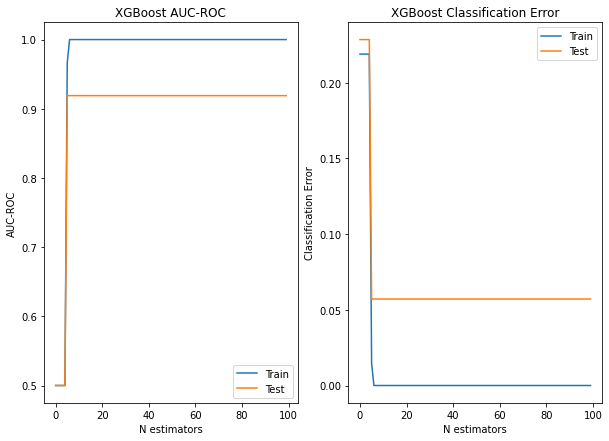

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt

# retrieve performance metrics
results = xgboot_clusterID_classification.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(10,7))

# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')


# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()

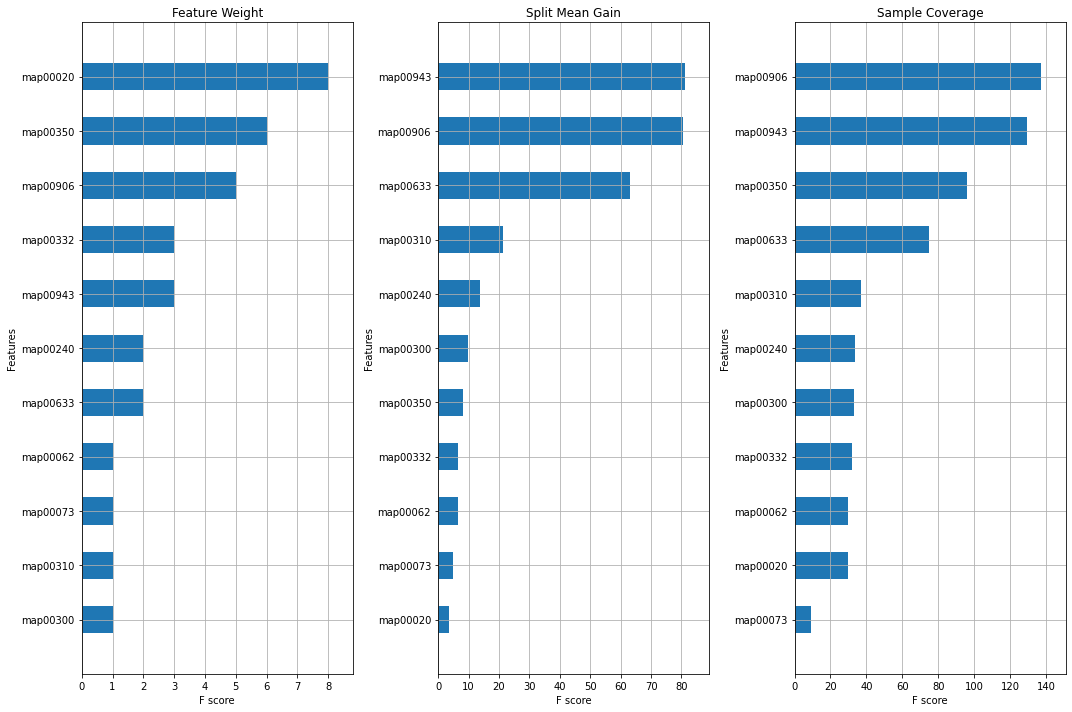

In [32]:
import xgboost as xgb

# store the winning model in a new variable
xgc = xgboot_clusterID_classification
# saving the feature names to the model
xgc.get_booster().feature_names = X_train.columns.to_list()

# Create the feature importances plot
fig, ax = plt.subplots(1, 3, figsize=(15,10))

# plot importances with feature weight
# "weight" is the number of times a feature appears in a tree
xgb.plot_importance(
    booster=xgc, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
)

# plot importances with split mean gain
# "gain" is the average gain of splits which use the feature
xgb.plot_importance(
    booster=xgc,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)

# plot importances with sample coverage
# "cover" is the average coverage of splits which use the feature 
# where coverage is defined as the number of samples affected by 
# the split max_num_features

xgb.plot_importance(
    xgc,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)

plt.tight_layout()
plt.show()